In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import dill

import numpy as np
import pandas as pd

from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

import gm2
import trfp
import plotting_functions as plt2
# import analysis_helper as helper
# import helper_function_candidates as helper_old
# import df_analysis_funcs as df_func
import helper_functions as helper

import muon_dist_config_run1 as dist_config
import field_map_config_run1 as map_config

from IPython.display import clear_output

# blinds = np.loadtxt('blinds.txt')
pair_dict = map_config.pair_dict

def bins(df, num_bins):
    xy_df = df.groupby(pd.cut(df.index.values, num_bins)).mean()
    x = np.empty(xy_df.shape[0])
    ii = 0
    for interval in xy_df.index:
        x[ii] = interval.mid
        ii = ii + 1
    y = xy_df.values
    return x, y


Welcome to JupyROOT 6.22/02


In [2]:
fig_width = 3.375 * 2  # inches, one column

plt.style.use('gm2.mplstyle')

xlabel_kwargs = dict(horizontalalignment='right', x=1.0, verticalalignment='bottom', y=0.0)
ylabel_kwargs = dict(horizontalalignment='right', x=0.0, verticalalignment='bottom', y=1.0, labelpad=10)

In [3]:
run = '1a'

filename = 'hdf5/2020-09-30_run_' + run + '.h5'

interp_dfs, keys, subrun_df = helper.read_dfs(filename)
run_pair_dict = pair_dict[run]

moment_dfs = helper.interp_to_moment(interp_dfs, keys)
# moment_dfs = blind_moments(moment_dfs, keys, blinds)
corrected_dfs = helper.moment_to_corrected(moment_dfs, keys)

baselines = helper.station_average(corrected_dfs, keys)


vtm_dfs = helper.calculate_vtms(corrected_dfs, keys, baselines, run_pair_dict)

bloch_style_dfs = helper.bloch_style_moments(corrected_dfs, keys)
baselines_bloch = helper.station_average(bloch_style_dfs, keys)

vtm_dfs_bloch = helper.calculate_vtms(bloch_style_dfs, keys, baselines_bloch, run_pair_dict)


Reading fp_df_1

Reading tr_df_1

Reading tr_df_2

Calculating moments for fp_df_1
Finished calculating all moments for 257281 events.      

Calculating moments for tr_df_1
Finished calculating all moments for 4386 events.

Calculating moments for tr_df_2
Finished calculating all moments for 4363 events.

Removing trolley footprints for tr_df_1
Removing trolley image from station 71.              
Removing trolley footprints for tr_df_2
Removing trolley image from station 71.              


Calculating trolley run baselines.

Calculating VTMs

Implementing Bloch-style treatment of stations 1, 3, and 5.
fp_df_1
tr_df_1
tr_df_2
m5
Calculating trolley run baselines.

Calculating VTMs


Reading event 8780/8781 99.99%    
loop done: 100%                                    
Reading event 2630/2634 99.85%  
loop done: 100%                                    
Finished calculating all moments for 4386 events.
Removing trolley image from station 10.


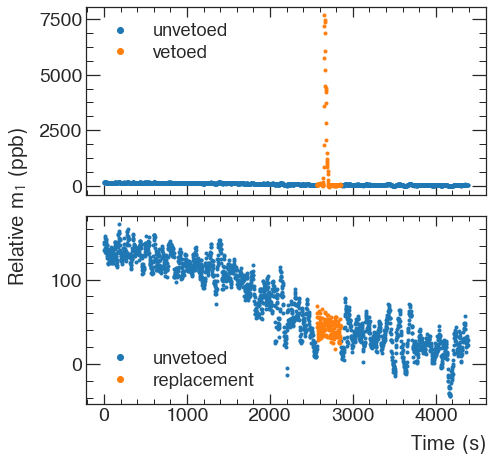

In [4]:
## fig:footprint_replacement

fig_name = 'fig_footprint_replacement'

st = 10
m = 1
df = 'tr_df_1'

interp_df = helper.root_to_pandas([3956], tr_run=True, sanitize=False, prefix='FieldPlainRootOutput_')
moment_df = helper.calc_moment_df(interp_df)

veto_extent=25
# no_mask_df = moment_dfs[df].copy()
no_mask_df = moment_df.copy()
t0 = no_mask_df.index.values[0]
no_mask_df.index -= t0
index = no_mask_df.index.values

print '\rRemoving trolley image from station '+str(st)+'.',

# veto when trolley is close to station

veto_low = (trfp.STATION_BARCODE_PHI[st]-1.5-veto_extent/2)%360
veto_high = (trfp.STATION_BARCODE_PHI[st]-1.5+veto_extent/2)%360
if veto_low < veto_high:
    veto_mask = (no_mask_df['tr_phi']>veto_low) & (no_mask_df['tr_phi']<veto_high)
else:  # this happens when wrapping around 360 deg
    veto_mask = (no_mask_df['tr_phi']>veto_low) | (no_mask_df['tr_phi']<veto_high)

# no longer dealing with m6 in the fixed probes


stm = 'st'+str(st)+',m'+str(m)

# calculate local drift

times = no_mask_df.index.values[~veto_mask]
freqs = no_mask_df[stm][~veto_mask]

local_drift_fit = np.polyfit(times, freqs, 5)
local_drift = np.polyval(local_drift_fit, no_mask_df.index.values)

# need to average other side of ring
all_good_stations = np.arange(6,72)  # not using the inflector stations
no_ground_loop_stations = np.array(range(6,16)+range(64,72))  # vaid for 25 deg veto

# next need to average all good stations that are not within 3 of current station
if st not in range(16, 23):  # note that these ranged were chosen for 25 deg veto
    averaging_stations = np.delete(all_good_stations,
                                   np.argwhere((np.abs((all_good_stations - st)%72)<=3)
                                              | (np.abs((all_good_stations - st)%72)>=69))
                                  )
else:
    averaging_stations = np.delete(no_ground_loop_stations,
                                   np.argwhere((np.abs((no_ground_loop_stations - st)%72)<=3)
                                              | (np.abs((no_ground_loop_stations - st)%72)>=69))
                                  )
avg_stms = ['st'+str(avg_st)+',m'+str(m+1) for avg_st in averaging_stations]
replacement = no_mask_df[avg_stms].mean(axis=1)

# calculate global drift
global_drift_fit = np.polyfit(index[veto_mask], replacement[veto_mask], 1)
global_drift = np.polyval(global_drift_fit, index[veto_mask])

# subtract global drift from replacement
replacement = replacement[veto_mask] - global_drift

# add local drifts
replacement = replacement + local_drift[veto_mask]

no_mask_df[stm][veto_mask] = replacement

# raw_data = moment_dfs[df][stm].copy()
raw_data = moment_df[stm].copy()
raw_data.index -= raw_data.index.values[0]

x0, y0 = bins(raw_data[~veto_mask], raw_data[~veto_mask].size/2)
x3, y3 = bins(raw_data[veto_mask], raw_data[veto_mask].size/2)

unvetoed = no_mask_df[stm][~veto_mask].copy()
x1, y1 = bins(unvetoed, unvetoed.size/2)
replace = no_mask_df[stm][veto_mask].copy()
x2, y2 = bins(replace, replace.size/2)

fig2, axs2 = plt.subplots(2, 1, sharex=True)

axs2[0].plot(x0, (y0+61.74e6-61.792e6-40)/61.79e6*1e9, '.', ms=6, label='unvetoed')
axs2[0].plot(x3, (y3+61.74e6-61.792e6-40)/61.79e6*1e9, '.', ms=6, label='vetoed')
axs2[0].legend(markerscale=2, loc='upper left')

axs2[1].plot(x1, (y1+61.74e6-61.792e6-40)/61.79e6*1e9, '.', ms=6, label='unvetoed')
axs2[1].plot(x2, (y2+61.74e6-61.792e6-40)/61.79e6*1e9, '.', ms=6, label='replacement', color='C1')
axs2[1].legend(markerscale=2, loc='lower left')

axs2[1].set_xlabel('Time (s)', **xlabel_kwargs)
# axs2[0].set_ylabel('NMR freq [Hz]', **ylabel_kwargs)
# axs2[1].set_ylabel('NMR freq [Hz]', **ylabel_kwargs)
fig2.text(-0.025, 0.55, r'Relative m$_1$ (ppb)', va='center', rotation='vertical', fontsize=20)

# fig2.text(0, 1, 'NMR freq [Hz]', va='center', rotation='vertical')

fig2.align_ylabels()
fig2.set_size_inches(fig_width, fig_width)
fig2.tight_layout()

# fig2.savefig('figures/run_1/'+fig_name+'.png', dpi=300, bbox_inches='tight')
# pickle.dump(axs2, open('figures/run_1/'+fig_name+'.pickle', 'wb'))

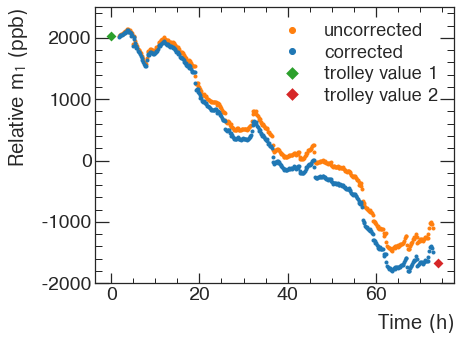

In [12]:
## fig:backward_interp
fig_name = 'fig_backward_interp'

fig1, axs1 = plt.subplots(1,1)

st = 16
m = 1

df = 'fp_df_1'
stm = 'st'+str(st)+',m'+str(m)
stm5 = 'st'+str(st)+',m5'

x0 = 0
x1 = (baselines['time']['tr_df_2'][st] - baselines['time']['tr_df_1'][st])/3600.


pre_corr = (moment_dfs[df][stm] - baselines['fp']['tr_df_1'][st,m-1] + baselines['tr']['tr_df_1'][st,m-1]
            + 2.631605 * (moment_dfs[df][stm5] - baselines['fp']['tr_df_1'][st,4])
           )
x, pre_corr = bins(pre_corr, pre_corr.size/600)
post_corr = vtm_dfs[df][stm]
_, post_corr = bins(post_corr, post_corr.size/600)

x = x - baselines['time']['tr_df_1'][st]
x = x/3600.

axs1.plot(x, (pre_corr+61.74e6-61.792e6)/61.79e6*1e9, '.', markersize=6, color='C1', label='uncorrected')
axs1.plot(x, (post_corr+61.74e6-61.792e6)/61.79e6*1e9, '.', markersize=6, color='C0', label='corrected')

axs1.plot(x0, (baselines['tr']['tr_df_1'][st,m-1]+61.74e6-61.792e6)/61.79e6*1e9, 'D', color='C2', mew=5, markersize=2, label='trolley value 1')
axs1.plot(x1, (baselines['tr']['tr_df_2'][st,m-1]+61.74e6-61.792e6)/61.79e6*1e9, 'D', color='C3', mew=5, markersize=2, label='trolley value 2')

axs1.legend(markerscale=2)

axs1.set_xlabel('Time (h)', **xlabel_kwargs)
axs1.set_ylabel(r'Relative m$_1$ (ppb)', **ylabel_kwargs)

axs1.set_ylim((-2000,2500))

fig1.set_size_inches(fig_width,0.75*fig_width)
fig1.tight_layout()

# fig1.savefig('figures/run_1/'+fig_name+'.png', dpi=300, bbox_inches='tight')
# pickle.dump(axs1, open('figures/run_1/'+fig_name+'.pickle', 'wb'))

# fig1.savefig('figures/run_1/'+fig_name+'-forPeter-2.png', dpi=300, bbox_inches='tight')

In [4]:
weight = (trfp.STATION_BARCODE_EDGES[1:] - trfp.STATION_BARCODE_EDGES[:-1])
weight[2] = (weight[2] + 360)
weight = weight/360

df = pd.DataFrame()
for run in map_config.subruns:
    print run
    _df = pd.read_hdf('/data2/aetb/2020-09-30_purcell_maps.h5', key='run_'+run)
    for m in range(9):
        stm = ['st'+str(st)+',m'+str(m+1) for st in range(72)]
        _df['m'+str(m+1)] = _df[stm].multiply(weight).sum(axis=1)
    df = df.append(_df)
    print df.shape


1a1
(257281, 657)
1b1
(508966, 657)
1b2
(730185, 657)
1c1
(990019, 657)
1c2
(1191060, 657)
1c3
(1425393, 657)
1d2
(1732890, 657)
1d3
(1984373, 657)
1d4
(2294847, 657)
1d5
(2563438, 657)
1d6
(2844298, 657)


840.74 ;  1.11
838.64  --  842.32


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


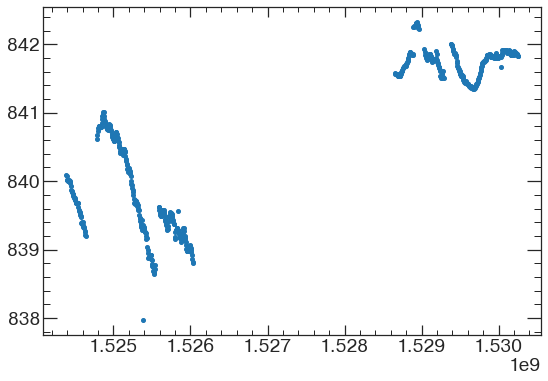

In [36]:
m = 'm1'
_x, _y = bins(df[m], df[m].size/2400)

print np.round(np.nanmean(_y)/61.79, 2), '; ', np.round(np.nanstd(_y)/61.79, 2)
print np.round(np.nanmin(_y[_y/61.79 > 837.98])/61.79, 2), ' -- ', np.round(np.nanmax(_y)/61.79, 2)
# print np.round(np.nanmin(_y)/61.79, 2), ' -- ', np.round(np.nanmax(_y)/61.79, 2)
plt.plot(_x, _y/61.79, '.')

nan

In [ ]:
m = 'm9'

print np.round(df[m].min().min()/61.79, 2), ' -- ', np.round(df[m].max().max()/61.79,2)
print
print np.round(df[['st'+str(st)+','+m  for st in range(72)]].min().min()/61.79, 2), ' -- ', np.round(df[['st'+str(st)+','+m for st in range(72)]].max().max()/61.79, 2)


In [ ]:
df.to_hdf('hdf5/full_run1.h5', key='run1')

In [3]:
## fig:run1_track

fig_name = 'fig_run1_track'

weight = (trfp.STATION_BARCODE_EDGES[1:] - trfp.STATION_BARCODE_EDGES[:-1])
weight[2] = (weight[2] + 360)
weight = weight/360

x = np.empty(0)
y1 = np.empty(0)
y2 = np.empty(0)
for run in map_config.subruns:
    print run
    df = pd.read_hdf('/data2/aetb/2020-09-30_purcell_maps.h5', key='run_'+run)
    for m in range(2):
        stm = ['st'+str(st)+',m'+str(m+1) for st in range(72)]
        df['m'+str(m+1)] = df[stm].multiply(weight).sum(axis=1)
    _x, _y1 = bins(df['m1'], df['m1'].size/1200)
    _x, _y2 = bins(df['m2'], df['m2'].size/1200)
    x = np.append(x, _x)
    y1 = np.append(y1, _y1)
    y2 = np.append(y2, _y2)
    
x = (x-x[0])/(3600*24)


1a1
1b1
1b2
1c1
1c2
1c3
1d2
1d3
1d4
1d5
1d6


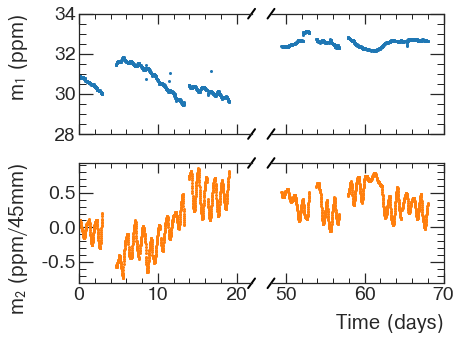

In [6]:
fig_name = 'fig_run1_track'

fig5, axs5 = plt.subplots(2, 2)

axs5[0,0].plot(x, (y1 + 61.74e6 - 61.79e6)/61.79e6*1e6, '.', ms=4)
axs5[0,0].set_xlim([0,21.9])
axs5[0,0].set_xticks([0,10,20])

axs5[0,1].plot(x, (y1 + 61.74e6 - 61.79e6)/61.79e6*1e6, '.', ms=4, label='dipole')
axs5[0,1].set_xlim([48.1,70])

axs5[0,0].set_ylim([28,34])
axs5[0,1].set_ylim([28,34])

axs5[0,0].spines['right'].set_visible(False)
axs5[0,1].spines['left'].set_visible(False)
axs5[0,0].tick_params(which='both', right=False, labelbottom=False)
axs5[0,1].tick_params(which='both', left=False, labelleft=False, labelbottom=False)

axs5[1,0].plot(x, y2/61.79e6*1e6, '.', ms=4, color='C1')
axs5[1,0].set_xlim([0,21.9])
axs5[1,0].set_xticks([0,10,20])

axs5[1,1].plot(x, y2/61.79e6*1e6, '.', ms=4, label='n quad', color='C1')
axs5[1,1].set_xlim([48.1,70])

axs5[1,0].spines['right'].set_visible(False)
axs5[1,1].spines['left'].set_visible(False)
axs5[1,0].tick_params(which='both', right=False)
axs5[1,1].tick_params(which='both', left=False, labelleft=False)

# fig5.text(0, 0.5, 'NMR freq [Hz]', va='center', rotation='vertical')
# fig5.text(0.5, 0, 'Time (days)', ha='center')

axs5[0,0].set_ylabel(r'm$_1$ (ppm)', **ylabel_kwargs)
axs5[1,0].set_ylabel(r'm$_2$ (ppm/45mm)', **ylabel_kwargs)

# axs5[1,0].set_xlabel('Time [days]', **xlabel_kwargs)
axs5[1,1].set_xlabel('Time (days)', **xlabel_kwargs)


d = .02  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=axs5[0,0].transAxes, color='k', clip_on=False)
axs5[0,0].plot((1-d, 1+d), (1-2*d, 1+2*d), **kwargs)        # top-left diagonal
axs5[0,0].plot((1-d, 1+d), (-2*d, 2*d), **kwargs)  # botton-left diagonal

kwargs = dict(transform=axs5[1,0].transAxes, color='k', clip_on=False)
axs5[1,0].plot((1-d, 1+d), (1-2*d, 1+2*d), **kwargs)        # top-left diagonal
axs5[1,0].plot((1-d, 1+d), (-2*d, 2*d), **kwargs)  # botton-left diagonal

kwargs = dict(transform=axs5[0,1].transAxes, color='k', clip_on=False)
axs5[0,1].plot((-d, d), (1-2*d, 1+2*d), **kwargs)        # top-right diagonal
axs5[0,1].plot((-d, d), (-2*d, 2*d), **kwargs)  # botton-right diagonal

kwargs = dict(transform=axs5[1,1].transAxes, color='k', clip_on=False)
axs5[1,1].plot((-d, d), (1-2*d, 1+2*d), **kwargs)        # top-right diagonal
axs5[1,1].plot((-d, d), (-2*d, 2*d), **kwargs)  # botton-right diagonal

fig5.align_ylabels()
fig5.set_size_inches(fig_width, 0.75*fig_width)
fig5.tight_layout()

fig5.savefig('figures/run_1/'+fig_name+'.png', dpi=300, bbox_inches='tight')
pickle.dump(axs5, open('figures/run_1/'+fig_name+'.pickle', 'wb'))

In [3]:
##############################
### Muon weighting figures ###
##############################

data_run = '1a1'

vtm_file = dist_config.config_dict[data_run][0]
vtm_key = dist_config.config_dict[data_run][1]
interp_file = dist_config.config_dict[data_run][2]
interp_key_1 = dist_config.config_dict[data_run][3]
interp_key_2 = dist_config.config_dict[data_run][4]
gold_subruns_file = dist_config.config_dict[data_run][5]
beam_files = dist_config.config_dict[data_run][6]

weight = np.diff(trfp.geometry.STATION_BARCODE_EDGES)
weight[2] = weight[2]+360
weight = weight/360

vtm_df = pd.read_hdf(vtm_file, key=vtm_key)

tr_interp_df_1 = pd.read_hdf(interp_file, key=interp_key_1)
t_start = np.mean(tr_interp_df_1.index.values)
tr_interp_df_2 = pd.read_hdf(interp_file, key=interp_key_2)
t_end = np.mean(tr_interp_df_2.index.values)
if data_run == '1d6': t_end = np.inf  # deals with not having a closing trolley run for 1d6
else: t_end = np.mean(tr_interp_df_2.index.values)

# Import a gold subrun list

subrun_df = pd.read_hdf(interp_file, key='subrun_df')
gold_subruns = np.loadtxt(gold_subruns_file)
gold_subruns_df = pd.DataFrame(gold_subruns.astype(int), columns=['run', 'subrun']).merge(subrun_df, on=['run', 'subrun'])
gold_subruns_df = gold_subruns_df[(gold_subruns_df['start_gps']>=t_start) & (gold_subruns_df['end_gps']<=t_end)]

# need to bin into subruns

vtm_interp = interp1d(vtm_df.index, vtm_df.values, axis=0)
times = gold_subruns_df['start_gps'].append(gold_subruns_df['end_gps'])

boundary_df = pd.DataFrame(vtm_interp(times), index=times, columns=vtm_df.columns)

vtm_interp_df = vtm_df.append(boundary_df).sort_index()

boundary_cut = pd.IntervalIndex.from_arrays(gold_subruns_df['start_gps'], gold_subruns_df['end_gps'], closed='both')
vtm_cut = pd.cut(vtm_interp_df.index, boundary_cut)

def avg_technique(bin_):
    numer = np.trapz(bin_, x=bin_.index.values, axis=0)
    denom = np.max(bin_.index.values)-np.min(bin_.index.values)

    return numer/denom

avg_field = vtm_interp_df.groupby(vtm_cut).apply(avg_technique)
avg_df = pd.DataFrame.from_dict(dict(zip(avg_field.index, avg_field.values)), orient='index', columns=vtm_df.columns)
avg_df['start_gps'] = [interval[0] for interval in avg_df.index.to_tuples().values]
avg_df['end_gps'] = [interval[1] for interval in avg_df.index.to_tuples().values]

output_df = gold_subruns_df[['run', 'subrun', 'start_gps', 'end_gps', 'ctags']].copy()
output_df = output_df.merge(avg_df, on=['start_gps', 'end_gps'])

# azimuthally average the field by subrun
for m in range(9):
    stm_list = ['st'+str(st)+',m'+str(m+1) for st in np.arange(72)]
    output_df['m'+str(m+1)] = output_df[stm_list].multiply(weight).sum(axis=1)

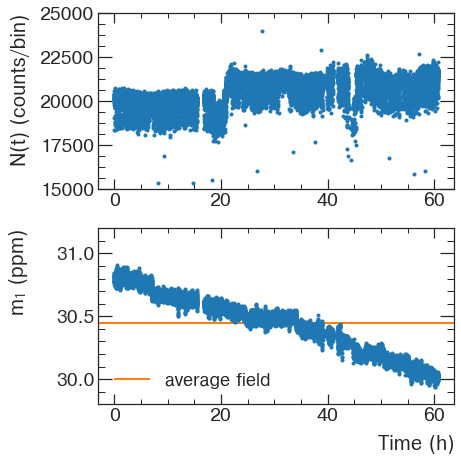

In [4]:
fig_name = 'fig_muon_avg_time'

x = (output_df['start_gps'] + output_df['end_gps']).values / 2
x = (x - x[0])/3600

y1 = output_df['ctags'].values
y2 = output_df['m1'].values + 61.74e6

mean_y2 = np.dot(y1,y2)/np.sum(y1)

fig7, axs7 = plt.subplots(2,1)

axs7[0].plot(x, y1, '.', markersize=6)
x1, x2 = axs7[0].get_xlim()
axs7[1].hlines((mean_y2-61.79e6)/61.79, x1, x2, color='C1', label='average field')
axs7[1].plot(x, (y2-61.79e6)/61.79, '.', markersize=6)
axs7[1].set_xlim([x1,x2])
axs7[1].legend(loc='lower left')

axs7[0].set_ylim([15000,25000])
axs7[1].set_ylim([29.8,31.2])
axs7[0].set_ylabel('N(t) (counts/bin)', **ylabel_kwargs)
axs7[1].set_xlabel('Time (h)', **xlabel_kwargs)
axs7[1].set_ylabel(r'm$_1$ (ppm)', **ylabel_kwargs)

fig7.align_ylabels()
fig7.set_size_inches(fig_width,1*fig_width)
fig7.tight_layout()

fig7.savefig('figures/run_1/'+fig_name+'.png', dpi=300)
pickle.dump(axs7, open('figures/run_1/'+fig_name+'.pickle', 'wb'))

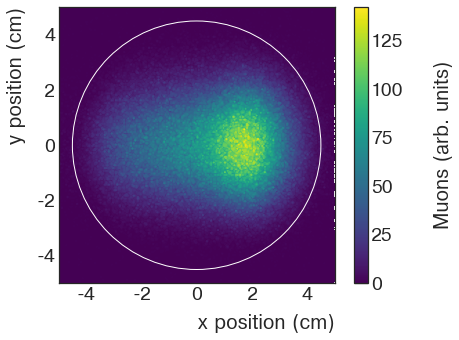

In [9]:
## fig:sample_muon_distribution

fig_name = 'fig_sample_muon_dist'

beam_filename = 'BeamSpot_'+str(beam_files[0][0])+'_'+str(beam_files[0][1])+'.root'

_beam, beam_x, beam_y = gm2.trfp.conv.loadBeamNew(beam_filename)
beam_x = beam_x/10
beam_y = beam_y/10
_beam = np.transpose(_beam)

X, Y = np.meshgrid(beam_x, beam_y)

fig8, axs8 = plt.subplots(1)

map8 = axs8.contourf(X, Y, _beam, levels=500, cmap='viridis')
axs8.set_aspect('equal')

axs8.add_artist(plt.Circle((0, 0), 4.5, fill=False))

axs8.set_xlim(-5,5)
axs8.set_ylim(-5,5)
axs8.set_xticks([-4, -2, 0, 2, 4])
axs8.set_yticks([-4, -2, 0, 2, 4])
axs8.set_xlabel('x position (cm)', **xlabel_kwargs)
axs8.set_ylabel('y position (cm)', **ylabel_kwargs)

cbar8 = fig8.colorbar(map8, shrink=1, ticks=[0, 25, 50, 75, 100, 125])
cbar8.set_label('Muons (arb. units)')

fig8.set_size_inches(fig_width, .75*fig_width)
fig8.tight_layout()

fig8.savefig('figures/run_1/'+fig_name+'.png', dpi=300)
pickle.dump(axs8, open('figures/run_1/'+fig_name+'.pickle', 'wb'))


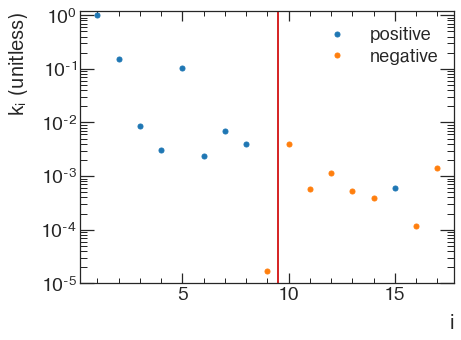

In [10]:
## fig:k_i_plot

fig_name = 'fig_k_i_plot'

def parameterize_beam(beam, beam_x, beam_y):
    x, y = np.meshgrid(beam_x, beam_y)

    dx = np.mean(np.diff(beam_x))
    dy = np.mean(np.diff(beam_y))
    
    _MULTIPOLE_ORDER = [0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 7, 7, 8, 10, 12]
    _MULTIPOLE_SKEW = [0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0]

    order = _MULTIPOLE_ORDER
    skew = _MULTIPOLE_SKEW
    multipole = trfp.matrices.__multipole

    n = len(order)
    k = np.zeros(n)

    for i in range(n):
        f = multipole(order[i], skew[i], 1, x, y)
        k[i] = np.sum(f*beam*dx*dy)/np.sum(beam*dx*dy)
    return k

beam_avg = np.zeros([200,200])

for ii in range(len(beam_files)):
    
    beam_filename = 'BeamSpot_'+str(beam_files[ii][0])+'_'+str(beam_files[ii][1])+'.root'

    _beam, beam_x, beam_y = gm2.trfp.conv.loadBeamNew(beam_filename)
    beam_x = beam_x/10
    beam_y = beam_y/10
    _beam = np.transpose(_beam)
    beam_avg += _beam
    
k_avg = parameterize_beam(beam_avg, beam_x, beam_y)
# k_avg = k_avg[:9]

fig9, axs9 = plt.subplots(1)

axs9.semilogy(np.arange(1, k_avg.size+1), k_avg, '.', ms=10, label='positive')
axs9.semilogy(np.arange(1, k_avg.size+1), -k_avg, '.', ms=10, label='negative')
axs9.vlines(9.5, 1e-5, 1.2, color='C3')
axs9.set_ylim(1e-5, 1.2)
axs9.legend(markerscale=1)

axs9.set_ylabel(r'k$_i$ (unitless)', **ylabel_kwargs)
axs9.set_xlabel('i', **xlabel_kwargs)

fig9.set_size_inches(fig_width, .75*fig_width)
fig9.tight_layout()

fig9.savefig('figures/run_1/'+fig_name+'.png', dpi=300)
pickle.dump(axs9, open('figures/run_1/'+fig_name+'.pickle', 'wb'))

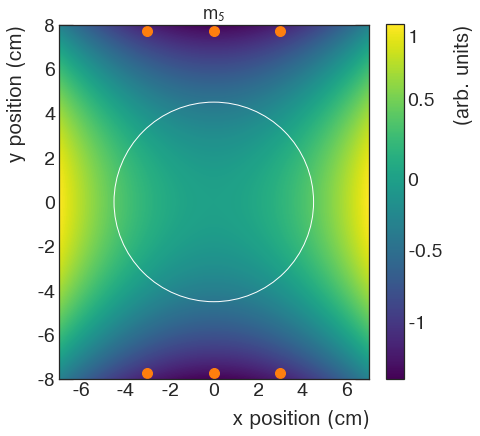

In [20]:
## sextupole aliasing figure

fig_name = 'fig_sext_alias'

multipole = trfp.matrices.__multipole

X, Y = np.meshgrid(np.linspace(-7,7,1001), np.linspace(-8,8,1001))

B = trfp.matrices.__multipole(2, 0, 1, X, Y)

fig11, axs11 = plt.subplots(1)

map11 = axs11.contourf(X, Y, B, levels=500, cmap='viridis')
axs11.set_aspect(5./8.)

axs11.plot(trfp.geometry.FP6_X, trfp.geometry.FP6_Y, '.', ms=20, color='C1')

axs11.add_artist(plt.Circle((0, 0), 4.5, fill=False))

axs11.set_xlim(-7,7)
axs11.set_ylim(-8,8)
axs11.set_xticks([-6, -4, -2, 0, 2, 4, 6])
axs11.set_aspect('equal')
axs11.set_yticks([-8, -6, -4, -2, 0, 2, 4, 6, 8])
axs11.set_xlabel('x position (cm)', **xlabel_kwargs)
axs11.set_ylabel('y position (cm)', **ylabel_kwargs)
cbar11 = plt.colorbar(map11, ax=axs11, ticks=[-2.25, -1.125, 0, 1.25, 2.25], fraction=0.047*8/7.32)
cbar11.ax.set_yticklabels(['-1', '-0.5', '0', '0.5', '1'])
cbar11.set_label('(arb. units)', horizontalalignment='right', x=0.0, verticalalignment='bottom', y=1.0)

axs11.set_title(r'm$_5$ ')

fig11.set_size_inches(fig_width, fig_width)
fig11.tight_layout()

fig11.savefig('figures/run_1/'+fig_name+'.png', dpi=300)
pickle.dump(axs11, open('figures/run_1/'+fig_name+'.pickle', 'wb'))
